### Numerical Model for Ocean Flow
Sierra Stevenson under mentorship of Dr. Marcelo Chamecki

We are solving the system of equations

$$
\begin{cases}

\frac{\partial{\bar{u}}}{\partial{t}} &= f(\bar{v} - v_g) + \frac{\partial{k}}{\partial{z}}  \frac{\partial{\bar{u}}}{\partial{z}} + k \frac{\partial{^2\bar{u}}}{\partial{z^2}} 
\\
\frac{\partial{\bar{v}}}{\partial{t}} &= f(\bar{u} - u_g) + \frac{\partial{k}}{\partial{z}}  \frac{\partial{\bar{v}}}{\partial{z}} + k \frac{\partial{^2\bar{v}}}{\partial{z^2}}

\end{cases}
$$

with boundary conditions

*surface ($z=0$):*  $k \frac{\partial{\bar{u}}}{\partial{z}} = \frac{T_x}{\rho}$,  $k \frac{\partial{\bar{v}}}{\partial{z}} = \frac{T_y}{\rho}$

*bottom ($z=-\infty$):* $\bar{u} = u_g, \bar{v} = v_g$


Knowing $u_g, v_g, k(z),$ and $f$, we want to find $\bar{u}{z}$ and $\bar{v}{z}$.<br>Testing for for $k = const.$ now.
<p>

# Code

Import libraries

In [278]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Font style for plotting
plt.rcParams["font.family"] = "Georgia"
plt.rcParams["font.size"] = 10

Grid

In [279]:
# Time
T = 500000                          # total seconds
dt = 50                             # time step
Nt = int(T/dt)                      # number of time steps

# Space
Z = 100                             # total meters deep
Nz = abs(Z)                         # number of grid nodes
dz = 1                              # step in z
z = np.arange(0, -Z, -dz)           # z array from [0, -100]
z_K = (z + 0.5)                     # z array for K, staggered as i + 1/2
z_K = [int(i) for i in z_K]

# Print info
print(f"z_K:   {z_K[0]},   {z_K[1]},   ...,  {z_K[-1]}")
print(f"z:    {z[0]}, {z[1]}, ...,  {z[-1]}")
print(f"\nhours of simulation: {round(T/60/60,1)}")

z_K:   0,   0,   ...,  -98
z:    0, -1, ...,  -99

hours of simulation: 138.9


Constants

In [280]:
f = 7 * 10 ** (-5)                  # coriolis parameter
tau_x_over_rho = 10 ** (-4)         # wind stress (tau_x / rho)
tau_y_over_rho = 0                  # wind stress (tau_y / rho)
ug = 0                              # geostrophic velocity
vg = 0                              # geostrophic velocity
K = np.ones(Nz) * 10 ** -2          # eddy diffusivity
dKdz = (K[:-1] - K[1:])/dz          # dK/dz (0 for const. K)

# Print info
print(f"K:\t {K[0]}, {K[1]}, {K[2]},  ...,  {K[-1]}")
print(f"dKdz:\t {dKdz[0]}, {dKdz[1]}, {dKdz[2]},  ...,  {dKdz[-1]}")

K:	 0.01, 0.01, 0.01,  ...,  0.01
dKdz:	 0.0, 0.0, 0.0,  ...,  0.0


Textbook spiral

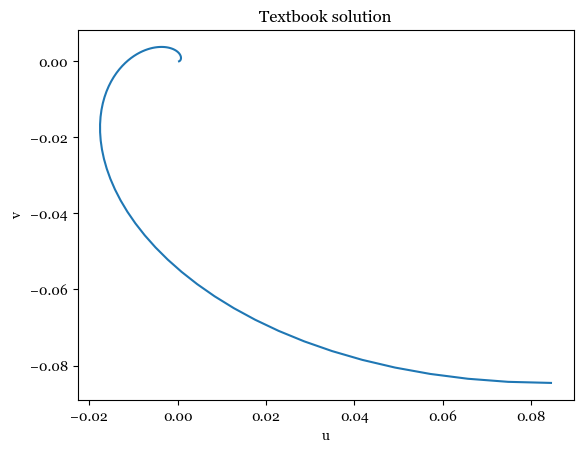

In [281]:
# Ekman spiral from Cushman
d = np.sqrt(2 * np.mean(K)/f)
u_book = ug + (np.sqrt(2)/(f*d) * np.exp(z[::dz]/d)) * (tau_x_over_rho * np.cos(z[::dz]/d - np.pi/4 ) - tau_y_over_rho * np.sin(z[::dz]/d - np.pi/4))
v_book = vg + (np.sqrt(2)/(f*d) * np.exp(z[::dz]/d)) * (tau_x_over_rho * np.sin(z[::dz]/d - np.pi/4 ) + tau_y_over_rho * np.cos(z[::dz]/d - np.pi/4))

plt.plot(u_book, v_book), plt.title("Textbook solution"), plt.xlabel("u"), plt.ylabel("v")
plt.show()

Main loop

___
<center>
Centered discretization <p>

$$
\begin{align}

\frac{\partial u_i}{\partial t} &= f (v_i - v_g) - \frac{1}{\Delta z} \biggr[-K_i \Bigl(\frac{\partial u}{\partial z}\Bigr)_{i-\frac{1}{2}} + K_{i+1} \Bigl(\frac{\partial u}{\partial z}\Bigr)_{i+\frac{1}{2}}\biggr]\\
&= f (v_i - v_g) + \frac{1}{\Delta z} \biggr[K_i \Bigl(\frac{\partial u}{\partial z}\Bigr)_{i-\frac{1}{2}} - K_{i+1} \Bigl(\frac{\partial u}{\partial z}\Bigr)_{i+\frac{1}{2}}\biggr]\\
&= f (v_i - v_g) + \frac{1}{\Delta z} \biggr[\Bigl(\frac{K_i}{\Delta z}\Bigr)(u_{i-1}-u_i)-\Bigl(\frac{K_{i+1}}{\Delta z}\Bigr)(u_{i}-u_{i+1})\biggr]\\
&= f (v_i - v_g) + \frac{1}{\Delta z^2} \biggr[K_i(u_{i-1}-u_i)-K_{i+1}(u_{i}-u_{i+1})\biggr]

\end{align}

$$

Boundary conditions <p>
$$
\begin{align}

\tau &= \rho_0 K \Bigl(\frac{du}{dz}\Bigr) \\
\frac{\tau}{\rho_0} &= K \Bigl(\frac{du}{dz}\Bigr) \\
\therefore 
\frac{\partial u_0}{\partial t} &= f (v_0 - v_g) + \frac{1}{\Delta z}\biggr[\frac{\tau}{\rho_0} -\Bigl(\frac{K_1}{\Delta z}\Bigr)(u_{0}-u_{1})\biggr]
\\
\\
u_{bottom} &= u_g

\end{align}

$$
___


In [282]:
# Functions to use in the loop

def F(u_val, v_val):
    F_u, F_v = np.zeros(Nz), np.zeros(Nz)

    # Interior nodes
    F_u[1:-1] =  (f * (v_val[1:-1] - vg) + (1/dz**2) * (K[1:-1]*(u_val[0:-2] - u_val[1:-1])) - (K[2:]*(u_val[1:-1] - u_val[2:])))
    F_v[1:-1] = (-f * (u_val[1:-1] - ug) + (1/dz**2) * (K[1:-1]*(v_val[0:-2] - v_val[1:-1])) - (K[2:]*(v_val[1:-1] - v_val[2:])))

    return F_u[1:-1], F_v[1:-1]

def BC(u_val, v_val):

    # Boundaries
    F_u_top =  (f * (v_val[0] - vg) + (1/dz) * (tau_x_over_rho - (K[1]/dz) * (u_val[0] - u_val[1])))
    F_v_top = (-f * (u_val[0] - ug) + (1/dz) * (tau_y_over_rho - (K[1]/dz) * (v_val[0] - v_val[1])))

    return F_u_top, F_v_top


___
<center>
Beginning loop with <br>
Runge-Kutta 4 <p>

$\tilde{u}_1 = u^n + \frac{\Delta t}{2}F(u^n) \newline$ <p>
$\tilde{u}_2 = u^n + \frac{\Delta t}{2}F(\tilde{u}_1^n) \newline$ <p>
$\tilde{u}_3 = u^n + \Delta t F(\tilde{u}_2^n) \newline$ <p>
$u^{n+1} = u^n + \frac{\Delta t}{6}[F(u^n) + 2F(\tilde{u_1}) + 2F(\tilde{u_2}) + F(\tilde{u_3})] \newline$ <p>

___


In [283]:
saverate = 10

# Initialize arrays for next time step
u,     v     = np.zeros(Nz), np.zeros(Nz)
u_1,   v_1   = np.zeros(Nz), np.zeros(Nz)
u_2,   v_2   = np.zeros(Nz), np.zeros(Nz)
u_3,   v_3   = np.zeros(Nz), np.zeros(Nz)
u_fut, v_fut = np.zeros(Nz), np.zeros(Nz)
u_saved, v_saved = np.zeros((Nz, int(Nt/saverate))), np.zeros((Nz, int(Nt/saverate)))

# RK4
for n in np.arange(0, T, dt):  # Loop thru time, Nt times
    
    # Intermediate 1
    F_u,  F_v  = F(u,v)
    BC_u, BC_v = BC(u,v)
    u_1[1:-1] = u[1:-1] + (dt/2) * F_u            # [0] gives the u array
    v_1[1:-1] = v[1:-1] + (dt/2) * F_v            # [1] gives the v array 
    u_1[0]    = u[0]    + (dt/2) * BC_u
    v_1[0]    = v[0]    + (dt/2) * BC_v
    u_1[-1], v_1[-1] = ug, vg
    
    # Intermediate 2
    F_u_1,  F_v_1  = F(u_1,v_1)
    BC_u_1, BC_v_1 = BC(u_1,v_1)
    u_2[1:-1] = u[1:-1] + (dt/2) * F_u_1
    v_2[1:-1] = v[1:-1] + (dt/2) * F_v_1
    u_2[0]    = u[0]    + (dt/2) * BC_u_1
    v_2[0]    = v[0]    + (dt/2) * BC_v_1
    u_2[-1], v_2[-1] = ug, vg

    # Intermediate 3
    F_u_2,  F_v_2  = F(u_2,v_2)
    BC_u_2, BC_v_2 = BC(u_2,v_2)
    u_3[1:-1] = u[1:-1] + (dt) * F_u_2
    v_3[1:-1] = v[1:-1] + (dt) * F_v_2
    u_3[0]    = u[0]    + (dt) * BC_u_2
    v_3[0]    = v[0]    + (dt) * BC_v_2
    u_3[-1], v_3[-1] = ug, vg

    # Next velocity vector in time
    F_u_3,  F_v_3  = F(u_3,v_3)
    BC_u_3, BC_v_3 = BC(u_3,v_3)
    u_fut[1:-1] = u[1:-1] + (dt/6) * (F_u  + 2*F_u_1  + 2*F_u_2  + F_u_3)
    v_fut[1:-1] = v[1:-1] + (dt/6) * (F_v  + 2*F_v_1  + 2*F_v_2  + F_v_3) 
    u_fut[0]    = u[0]    + (dt/6) * (BC_u + 2*BC_u_1 + 2*BC_u_2 + BC_u_3)
    v_fut[0]    = v[0]    + (dt/6) * (BC_v + 2*BC_v_1 + 2*BC_v_2 + BC_v_3) 
    u_fut[-1], v_fut[-1] = ug, vg

    # Update u and v to restart loop with new starting values
    u = np.copy(u_fut)
    v = np.copy(v_fut)

    # Save history
    if (n/dt)%saverate == 0:
        u_saved[:,int((n/dt)/saverate)] = np.copy(u)
        v_saved[:,int((n/dt)/saverate)] = np.copy(v)


In [286]:
# Get average value of u and v oscillations
u_avg = np.mean(u_saved[:,-200:], axis=1)
v_avg = np.mean(v_saved[:,-200:], axis=1)

Plots

$u$ vs. $v$ hodograph

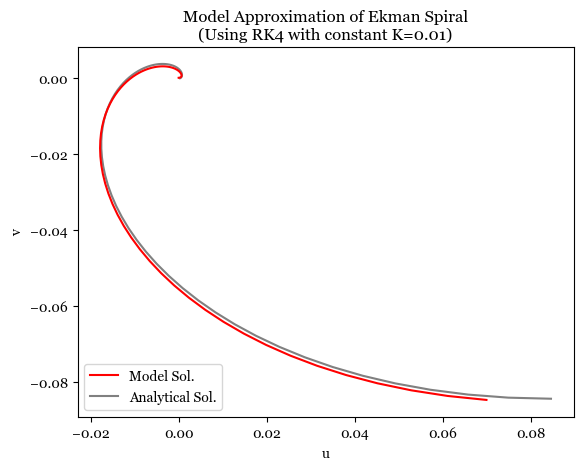

In [295]:
# Plot avg'd model solution
plt.plot(u_avg[1:], v_avg[1:], color='red', zorder=3, label="Model Sol.", ls="-")

# Analytical plot
plt.plot(u_book, v_book, color='gray', linestyle='-', label="Analytical Sol.")

# plt.scatter(0,0)
plt.xlabel("u")
plt.ylabel("v")
plt.title("Model Approximation of Ekman Spiral\n(Using RK4 with constant K=0.01)")
plt.legend(loc="lower left")
plt.show()

$u$ and $v$ depth profiles

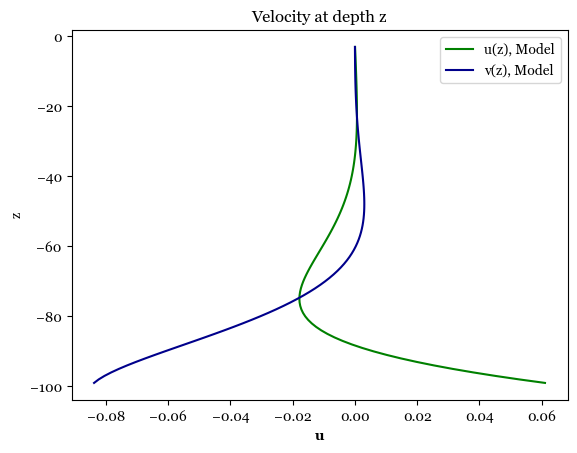

In [288]:
# Model plot
a = 2
b = -1

plt.plot(u_avg[a:b], z[b:a:-1], label="u(z), Model", color="green")
plt.plot(v_avg[a:b], z[b:a:-1], label="v(z), Model", color="darkblue")

# Analytical plot
# plt.plot(u_book, z, label="u(z), Analytical", color="darkgreen", alpha=0.5, linestyle="--")
# plt.plot(v_book, z, label="v(z), Analytical", color="indigo", alpha=0.5, linestyle="--")

# Plot labels
plt.xlabel("u", weight="bold")
plt.ylabel("z")
plt.title("Velocity at depth z")
plt.legend()
plt.show()

Time evolution of ($u_1, v_1$)

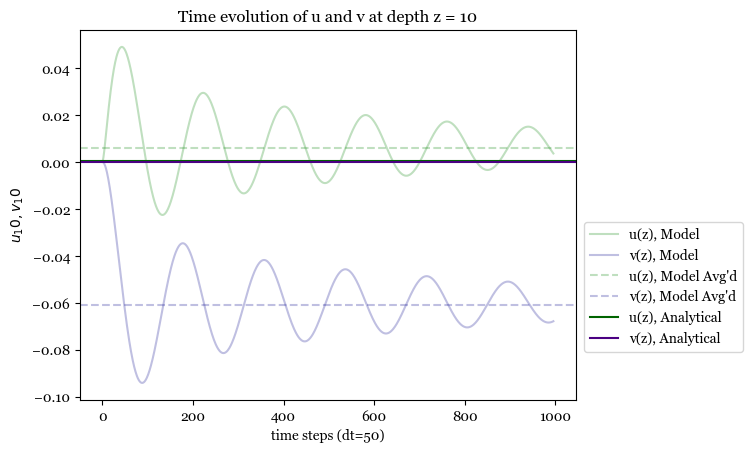

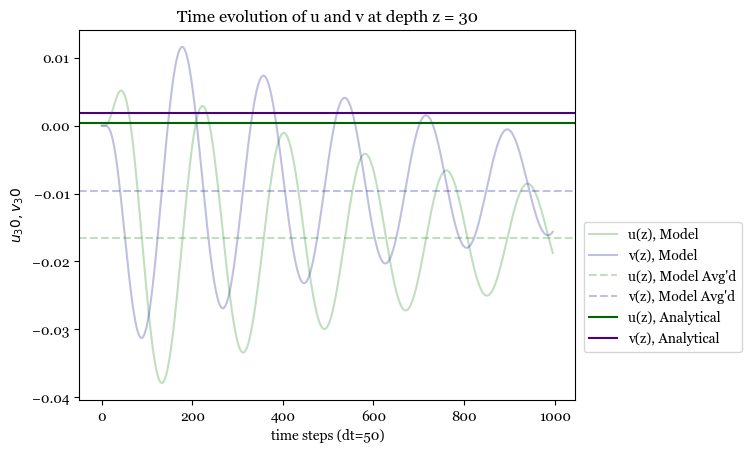

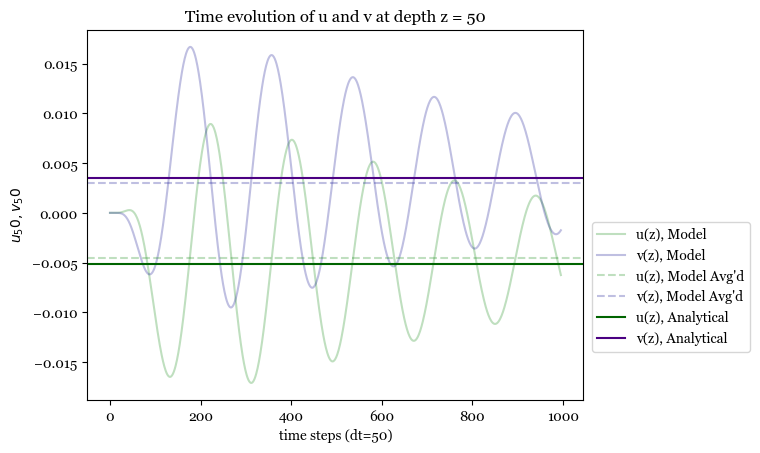

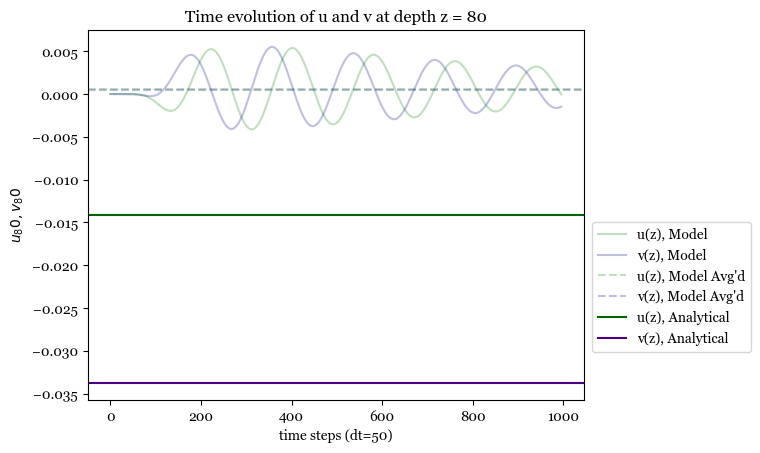

In [289]:
def PlotTimeEvolutionAt(depth):
    # Model plot
    plt.plot(u_saved[depth+1,2:-1], label="u(z), Model", color="green", alpha=0.25)
    plt.plot(v_saved[depth+1,2:-1], label="v(z), Model", color="darkblue", alpha=0.25)

    plt.axhline(u_avg[depth+1], label="u(z), Model Avg'd", color="green", alpha=0.25, ls="--")
    plt.axhline(v_avg[depth+1], label="v(z), Model Avg'd", color="darkblue", alpha=0.25, ls="--")

    # Analytical plot
    plt.axhline(u_book[-depth], label="u(z), Analytical", color="darkgreen")
    plt.axhline(v_book[-depth], label="v(z), Analytical", color="indigo")

    # Plot labels
    plt.xlabel(f"time steps (dt={dt})")
    plt.ylabel(f"$u_{depth}, v_{depth}$")
    plt.title(f"Time evolution of u and v at depth z = {depth}")
    plt.legend(bbox_to_anchor=[1.35,0.5])
    plt.show()

# PlotTimeEvolutionAt(1)
PlotTimeEvolutionAt(10)
PlotTimeEvolutionAt(30)
PlotTimeEvolutionAt(50)
PlotTimeEvolutionAt(80)